In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

import warnings

# Data

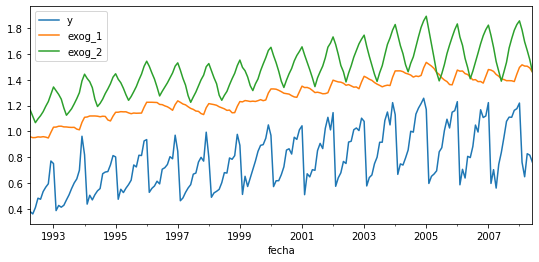

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data['exog_3'] = (["A"] * int(len(data)/2)) + (["B"] * (int(len(data)/2) +1))

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [4]:
forecaster = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags = 3,
             )
forecaster.get_feature_importance()

NotFittedError: `residuals` argument must be `pd.Series`. Got

In [40]:
transformer_exog = ColumnTransformer(
                   [('scale', StandardScaler(), ['exog_1']),
                    ('scale1', StandardScaler(), ['exog_2']),
                    ('onehot', OneHotEncoder(), ['exog_3'])],
                remainder='passthrough',
                verbose_feature_names_out=False)

forecaster = ForecasterAutoreg(lags=10, regressor=LinearRegression(), transformer_exog=transformer_exog)

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2', 'exog_3']])

forecaster.predict(steps=4, exog=data_test[['exog_1', 'exog_2', 'exog_3']])

2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
Freq: MS, Name: pred, dtype: float64

In [41]:
forecaster.predict_interval(steps=4, exog=data_test[['exog_1', 'exog_2', 'exog_3']], n_boot=10)

,pred,lower_bound,upper_bound
2005-07-01,0.874336,0.874336,0.874336
2005-08-01,1.006497,1.006497,1.006497
2005-09-01,1.094736,1.094736,1.094736
2005-10-01,1.027043,1.027043,1.027043


Test error (mse): 6.450238972855313e-30


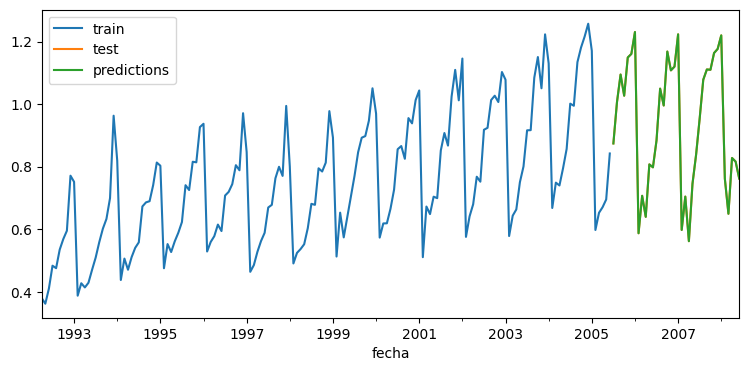

In [42]:
# Create and fit forecaster
# ==============================================================================
forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2', 'exog_3']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2', 'exog_3']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [43]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor= make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = False,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

NameError: name 'make_pipeline' is not defined

In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=10)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[6.21996921e-30]


In [ ]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with multiple exogenous variables

In [ ]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2] 
Window size: 2 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-01-02 13:28:53 
Last fit date: 2022-01-02 13:28:53 
Skforecast version: 0.4.2 

Test error (mse): 0.030285034610348982


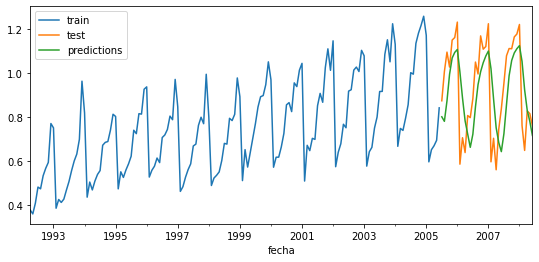

In [ ]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [ ]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04157249499273814



,lags,params,metric,max_depth,n_estimators
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.041572,5,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.042374,10,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.047357,5,100
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.047655,10,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.049627,10,100
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.050294,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.051669,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.052149,5,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.052404,5,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.052786,10,50


# Unit Testing

In [ ]:
# Unit test transform_series
# ==============================================================================
import pytest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe


def test_transform_series_when_transformer_is_None():
    """
    Test the output of transform_series when transformer is None.
    """
    input = pd.Series([1.16, -0.28, 0.07, 2.4, 0.25, -0.56, -1.42, 1.26, 1.78, -1.49])
    expected = input
    transformer = None
    results =  transform_series(
                    series = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_series_equal(results, expected)


def test_transform_series_when_transformer_is_StandardScaler():
    """
    Test the output of transform_series when transformer is StandardScaler.
    """
    input = pd.Series([1.16, -0.28, 0.07, 2.4, 0.25, -0.56, -1.42, 1.26, 1.78, -1.49],
                      name = 'y')
    expected = pd.Series([0.67596768, -0.47871021, -0.19805933,  1.67027365, -0.0537246,
                         -0.70323091, -1.39283021,  0.75615365,  1.17312067, -1.44896038],
                         name = 'y')
    transformer = StandardScaler()
    results =  transform_series(
                    series = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_series_equal(results, expected)

def test_transform_series_when_transformer_is_StandardScaler_and_inverse_transform_is_True():
    """
    Test the output of transform_series when transformer is StandardScaler.
    """
    input_1 = pd.Series([1.16, -0.28, 0.07, 2.4, 0.25, -0.56, -1.42, 1.26, 1.78, -1.49],
                      name = 'y')
    transformer = StandardScaler()
    transformer.fit(input_1.to_numpy().reshape(-1, 1))
    input_2 = transformer.transform(input_1.to_numpy().reshape(-1, 1))
    input_2 = pd.Series(input_2.flatten(), name= 'y')
    expected = input_1
    results =  transform_series(
                    series = input_2,
                    transformer = transformer,
                    fit = False,
                    inverse_transform = True
                )
    pd.testing.assert_series_equal(results, expected)


def test_transform_dataframe_when_transformer_is_None():
    """
    Test the output of transform_dataframe when transformer is None.
    """
    input = pd.DataFrame({
                'A': [1.16, -0.28, 0.07, 2.4, 0.25, -0.56, -1.42, 1.26, 1.78, -1.49],
                'B': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4,  2.7, 59.6]
            })  
    expected = input
    transformer = None
    results =  transform_dataframe(
                    df = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_frame_equal(results, expected)


def test_transform_dataframe_when_transformer_is_StandardScaler():
    """
    Test the output of transform_dataframe when transformer is StandardScaler.
    """
    input = pd.DataFrame({
                'A': [1.16, -0.28, 0.07, 2.4, 0.25, -0.56, -1.42, 1.26, 1.78, -1.49],
                'B': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4,  2.7, 59.6]
            })
    expected = pd.DataFrame({
                'A': [0.67596768, -0.47871021, -0.19805933,  1.67027365, -0.0537246 ,
                     -0.70323091, -1.39283021,  0.75615365,  1.17312067, -1.44896038],
                'B': [-1.47939551, -0.79158852,  0.6694926 ,  0.54739669,  0.27878567,
                      -0.09971166,  1.76428598,  0.14448017, -1.67474897,  0.64100356]
            })
    transformer = StandardScaler()
    results =  transform_dataframe(
                    df = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_frame_equal(results, expected)


def test_transform_dataframe_when_transformer_is_OneHotEncoder():
    """
    Test the output of transform_dataframe when transformer is OneHotEncoder.
    """
    input = pd.DataFrame({
                'col_1': ['a', 'a', 'a', 'a', 'b','b','b','b'],
                'col_2': ['a', 'a', 'a', 'a', 'b','b','b','b']
            })
    expected = pd.DataFrame({
                    'col_1_a': [1., 1., 1., 1., 0., 0., 0., 0.],
                    'col_1_b': [0., 0., 0., 0., 1., 1., 1., 1.],
                    'col_2_a': [1., 1., 1., 1., 0., 0., 0., 0.],
                    'col_2_b': [0., 0., 0., 0., 1., 1., 1., 1.]
               })
    transformer = OneHotEncoder()
    results =  transform_dataframe(
                    df = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_frame_equal(results, expected)


def test_transform_dataframe_when_transformer_is_ColumnTransformer():
    """
    Test the output of transform_dataframe when transformer is ColumnTransformer.
    """
    input = pd.DataFrame({
                'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })
    expected = pd.DataFrame({
              'col_1': [-1.76425513, -1.00989936, 0.59254869, 0.45863938,
                          0.1640389 , -0.25107995, 1.79326881, 0.01673866],
              'col_2_a': [1., 1., 1., 1., 0., 0., 0., 0.],
              'col_2_b': [0., 0., 0., 0., 1., 1., 1., 1.]
           })
    transformer = ColumnTransformer(
                    [('scale', StandardScaler(), ['col_1']),
                    ('onehot', OneHotEncoder(), ['col_2'])],
                    remainder = 'passthrough',
                    verbose_feature_names_out = False
                  )
    results =  transform_dataframe(
                    df = input,
                    transformer = transformer,
                    fit = True,
                    inverse_transform = False
                )
    pd.testing.assert_frame_equal(results, expected)


def test_transform_dataframe_exception_when_transformer_is_ColumnTransformer_and_inverse_transform_in_true():
    """
    Test that transform_dataframe raise exception when transformer is ColumnTransformer
    ans argument inverse_transform is True.
    """
    input = pd.DataFrame({
                'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })
    expected = pd.DataFrame({
              'col_1': [-1.76425513, -1.00989936, 0.59254869, 0.45863938,
                          0.1640389 , -0.25107995, 1.79326881, 0.01673866],
              'col_2_a': [1., 1., 1., 1., 0., 0., 0., 0.],
              'col_2_b': [0., 0., 0., 0., 1., 1., 1., 1.]
           })
    transformer = ColumnTransformer(
                    [('scale', StandardScaler(), ['col_1']),
                    ('onehot', OneHotEncoder(), ['col_2'])],
                    remainder = 'passthrough',
                    verbose_feature_names_out = False
                  )
    with pytest.raises(Exception):
        results =  transform_dataframe(
                        df = input,
                        transformer = transformer,
                        fit = True,
                        inverse_transform = True
                    )

test_transform_series_when_transformer_is_None()
test_transform_series_when_transformer_is_StandardScaler()
test_transform_series_when_transformer_is_StandardScaler_and_inverse_transform_is_True()
test_transform_dataframe_when_transformer_is_None()
test_transform_dataframe_when_transformer_is_StandardScaler()
test_transform_dataframe_when_transformer_is_OneHotEncoder()
test_transform_dataframe_when_transformer_is_ColumnTransformer()
test_transform_dataframe_exception_when_transformer_is_ColumnTransformer_and_inverse_transform_in_true()

In [ ]:
def test_create_train_X_y_output_when_exog_is_None_and_transformer_exog_is_not_None():
    '''
    Test the output of create_train_X_y when exog is None and transformer_exog
    is not None.
    '''

    forecaster = ForecasterAutoreg(
        regressor = LinearRegression(),
        lags = 5,
        transformer_exog = StandardScaler()
    )

    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4., 3., 2., 1., 0.],
                                    [5., 4., 3., 2., 1.],
                                    [6., 5., 4., 3., 2.],
                                    [7., 6., 5., 4., 3.],
                                    [8., 7., 6., 5., 4.]]),
                    index   = pd.RangeIndex(start=5, stop=10, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([5., 6., 7., 8., 9.]),
                    index = pd.RangeIndex(start=5, stop=10, step=1),
                    name = 'y'
                ))    
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])


def test_create_train_X_y_output_when_y_is_series_10_and_transformer_y_is_StandardScaler():
    '''
    Test the output of create_train_X_y when exog is None and transformer_exog
    is not None.
    '''

    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = StandardScaler()
                )

    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[-0.17407766, -0.52223297, -0.87038828, -1.21854359, -1.5666989 ],
                                    [0.17407766, -0.17407766, -0.52223297, -0.87038828, -1.21854359],
                                    [0.52223297,  0.17407766, -0.17407766, -0.52223297, -0.87038828],
                                    [0.87038828,  0.52223297,  0.17407766, -0.17407766, -0.52223297],
                                    [1.21854359,  0.87038828,  0.52223297,  0.17407766, -0.17407766]]),
                    index   = pd.RangeIndex(start=5, stop=10, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([0.17407766, 0.52223297, 0.87038828, 1.21854359, 1.5666989]),
                    index = pd.RangeIndex(start=5, stop=10, step=1),
                    name = 'y'
                ))

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])


def test_create_train_X_y_output_when_transformer_y_and_transformer_exog():
    '''
    Test the output of create_train_X_y when using transformer_y and transformer_exog.
    '''
    y = pd.Series(np.arange(8))
    exog = pd.DataFrame({
                'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })

    transformer_y = StandardScaler()
    transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                            ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                        )

    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = transformer_y,
                    transformer_exog= transformer_exog
                )


    expected = (pd.DataFrame(
                    data = np.array([[0.21821789, -0.21821789, -0.65465367, -1.09108945,
                                     -1.52752523, -0.25107995,  0.        ,  1.        ],
                                     [0.65465367,  0.21821789, -0.21821789, -0.65465367,
                                      -1.09108945, 1.79326881,  0.        ,  1.        ],
                                     [1.09108945,  0.65465367,  0.21821789, -0.21821789,
                                      -0.65465367, 0.01673866,  0.        ,  1.        ]]),
                    index   = pd.RangeIndex(start=5, stop=8, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'col_1',
                               'col_2_a', 'col_2_b']
                ),
                pd.Series(
                    np.array([0.65465367, 1.09108945, 1.52752523]),
                    index = pd.RangeIndex(start=5, stop=8, step=1),
                    name = 'y'
                ))

                
    results = forecaster.create_train_X_y(y=y, exog=exog)

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])






test_create_train_X_y_output_when_exog_is_None_and_transformer_exog_is_not_None()
test_create_train_X_y_output_when_y_is_series_10_and_transformer_y_is_StandardScaler()
test_create_train_X_y_output_when_transformer_y_and_transformer_exog()

In [ ]:
def test_create_train_X_y_output_when_exog_is_None_and_transformer_exog_is_not_None():
    '''
    Test the output of create_train_X_y when exog is None and transformer_exog
    is not None.
    '''

    forecaster = ForecasterAutoreg(
        regressor = LinearRegression(),
        lags = 5,
        transformer_exog = StandardScaler()
    )

    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4., 3., 2., 1., 0.],
                                    [5., 4., 3., 2., 1.],
                                    [6., 5., 4., 3., 2.],
                                    [7., 6., 5., 4., 3.],
                                    [8., 7., 6., 5., 4.]]),
                    index   = pd.RangeIndex(start=5, stop=10, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([5., 6., 7., 8., 9.]),
                    index = pd.RangeIndex(start=5, stop=10, step=1),
                    name = 'y'
                ))    
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])


def test_create_train_X_y_output_when_y_is_series_10_and_transformer_y_is_StandardScaler():
    '''
    Test the output of create_train_X_y when exog is None and transformer_exog
    is not None.
    '''

    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = StandardScaler()
                )

    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[-0.17407766, -0.52223297, -0.87038828, -1.21854359, -1.5666989 ],
                                    [0.17407766, -0.17407766, -0.52223297, -0.87038828, -1.21854359],
                                    [0.52223297,  0.17407766, -0.17407766, -0.52223297, -0.87038828],
                                    [0.87038828,  0.52223297,  0.17407766, -0.17407766, -0.52223297],
                                    [1.21854359,  0.87038828,  0.52223297,  0.17407766, -0.17407766]]),
                    index   = pd.RangeIndex(start=5, stop=10, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([0.17407766, 0.52223297, 0.87038828, 1.21854359, 1.5666989]),
                    index = pd.RangeIndex(start=5, stop=10, step=1),
                    name = 'y'
                ))

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])


def test_create_train_X_y_output_when_transformer_y_and_transformer_exog():
    '''
    Test the output of create_train_X_y when using transformer_y and transformer_exog.
    '''
    y = pd.Series(np.arange(8))
    exog = pd.DataFrame({
                'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })

    transformer_y = StandardScaler()
    transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                            ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                        )

    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = transformer_y,
                    transformer_exog= transformer_exog
                )


    expected = (pd.DataFrame(
                    data = np.array([[0.21821789, -0.21821789, -0.65465367, -1.09108945,
                                     -1.52752523, -0.25107995,  0.        ,  1.        ],
                                     [0.65465367,  0.21821789, -0.21821789, -0.65465367,
                                      -1.09108945, 1.79326881,  0.        ,  1.        ],
                                     [1.09108945,  0.65465367,  0.21821789, -0.21821789,
                                      -0.65465367, 0.01673866,  0.        ,  1.        ]]),
                    index   = pd.RangeIndex(start=5, stop=8, step=1),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'col_1',
                               'col_2_a', 'col_2_b']
                ),
                pd.Series(
                    np.array([0.65465367, 1.09108945, 1.52752523]),
                    index = pd.RangeIndex(start=5, stop=8, step=1),
                    name = 'y'
                ))

                
    results = forecaster.create_train_X_y(y=y, exog=exog)

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_series_equal(results[1], expected[1])






test_create_train_X_y_output_when_exog_is_None_and_transformer_exog_is_not_None()
test_create_train_X_y_output_when_y_is_series_10_and_transformer_y_is_StandardScaler()
test_create_train_X_y_output_when_transformer_y_and_transformer_exog()

In [ ]:
import pytest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def test_predict_interval_output_when_regressor_is_LinearRegression_with_transform_y():
    '''
    Test predict output when using LinearRegression as regressor and StandardScaler.
    '''
    y = pd.Series(
            np.array([-0.59,  0.02, -0.9 ,  1.09, -3.61,  0.72, -0.11, -0.4 ,  0.49,
                    0.67,  0.54, -0.17,  0.54,  1.49, -2.26, -0.41, -0.64, -0.8 ,
                    -0.61, -0.88])
        )
    transformer_y = StandardScaler()
    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = transformer_y,
                )
    forecaster.fit(y=y)
    predictions = forecaster.predict_interval(steps=5)
    expected = pd.DataFrame(
                data = np.array([[-0.1578203 , -2.02104471,  1.55076389],
                                [-0.18459942, -1.85211385,  1.49693466],
                                [-0.13711051, -1.82918043,  1.37837389],
                                [-0.01966358, -1.7522189 ,  1.31940346],
                                [-0.03228613, -1.77074022,  1.56056698]]),
                index = pd.RangeIndex(start=20, stop=25, step=1),
                columns = ['pred', 'lower_bound', 'upper_bound']
               )
    pd.testing.assert_frame_equal(predictions, expected)


def test_predict_interval_output_when_regressor_is_LinearRegression_with_transform_y_and_transform_exog():
    '''
    Test predict output when using LinearRegression as regressor, StandardScaler
    as transformer_y and transformer_exog as transformer_exog.
    '''
    y = pd.Series(
            np.array([-0.59,  0.02, -0.9 ,  1.09, -3.61,  0.72, -0.11, -0.4])
        )
    exog = pd.DataFrame({
                'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })

    transformer_y = StandardScaler()
    transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                            ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                        )
    forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 5,
                    transformer_y = transformer_y,
                    transformer_exog = transformer_exog,
                )
    forecaster.fit(y=y, exog=exog)
    predictions = forecaster.predict_interval(steps=5, exog=exog)
    expected = pd.DataFrame(
                data = np.array([[ 0.50619336,  0.50619336,  0.50619336],
                                [-0.09630298, -0.09630298, -0.09630298],
                                [ 0.05254973,  0.05254973,  0.05254973],
                                [ 0.12281153,  0.12281153,  0.12281153],
                                [ 0.00221741,  0.00221741,  0.00221741]]),
                index = pd.RangeIndex(start=8, stop=13, step=1),
                columns = ['pred', 'lower_bound', 'upper_bound']
               )
    pd.testing.assert_frame_equal(predictions, expected)



test_predict_interval_output_when_regressor_is_LinearRegression_with_transform_y()
test_predict_interval_output_when_regressor_is_LinearRegression_with_transform_y_and_transform_exog()

## test OneHot

In [ ]:
transformer.categories_

[array(['a', 'b'], dtype=object), array(['a', 'b'], dtype=object)]

In [ ]:
input_1 = pd.DataFrame({
                'col_1': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })
transformer = OneHotEncoder()
transformer.fit(input_1)
input_2 = transformer.transform(input_1)
input_3 = transformer.inverse_transform(input_2)

pd.DataFrame(input_3, columns=input_1.columns)

,col_1,col_2
0,a,a
1,a,a
2,a,a
3,a,a
4,b,b
5,b,b
6,b,b
7,b,b


In [ ]:
transformer.categories_

[array(['a', 'b'], dtype=object), array(['a', 'b'], dtype=object)]

In [ ]:

results =  transform_dataframe(
                df = df_fit,
                transformer = transformer,
                fit = False,
                inverse_transform = True
            )

In [ ]:
expected = pd.DataFrame({
                    'col_1_a': [1., 1., 1., 1., 0., 0., 0., 0.],
                    'col_1_b': [0., 0., 0., 0., 1., 1., 1., 1.],
                    'col_2_a': [1., 1., 1., 1., 0., 0., 0., 0.],
                    'col_2_b': [0., 0., 0., 0., 1., 1., 1., 1.]
               })

expected

,col_1_a,col_1_b,col_2_a,col_2_b
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0
5,0.0,1.0,0.0,1.0
6,0.0,1.0,0.0,1.0
7,0.0,1.0,0.0,1.0


In [ ]:
from skforecast.utils import transform_dataframe

transform_dataframe(
                    df = expected,
                    transformer = transformer,
                    fit = False,
                    inverse_transform = True
                )

ValueError: Shape of passed values is (8, 2), indices imply (8, 4)

In [ ]:
input_1 = pd.Series(['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                    name='col_1'
                   )
transformer = OneHotEncoder()
transformer.fit(input_1.to_numpy().reshape(-1, 1))
input_2 = transformer.transform(input_1.to_numpy().reshape(-1, 1))
input_3 = transformer.inverse_transform(input_2)

input_3

array([['a'],
       ['a'],
       ['a'],
       ['a'],
       ['b'],
       ['b'],
       ['b'],
       ['b']], dtype=object)

In [ ]:
input_1 = input_1.to_frame()

series_transformed = pd.Series(
                            data  = input_3.flatten(),
                            index = input_1.index,
                            name  = input_1.columns[0]
                          )

In [ ]:
series_transformed

0    a
1    a
2    a
3    a
4    b
5    b
6    b
7    b
Name: col_1, dtype: object

In [ ]:
from skforecast.utils import check_y

y = pd.Series(
            np.array([-0.59,  0.02, -0.9 , 1.09, -3.61,  0.72, -0.11, -0.4])
        )
exog = pd.DataFrame({
            'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4],
            'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
       })

transformer_y = StandardScaler()
transformer_exog = ColumnTransformer(
                        [('scale', StandardScaler(), ['col_1']),
                         ('onehot', OneHotEncoder(), ['col_2'])],
                        remainder = 'passthrough',
                        verbose_feature_names_out = False
                    )
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 5,
                transformer_y = transformer_y,
                transformer_exog = transformer_exog,
            )
forecaster.fit(y=y, exog=exog)
predictions = forecaster.predict_interval(steps=5, exog=exog)
expected = pd.DataFrame(
            data = np.array([[ 0.50619336,  0.50619336,  0.50619336],
                             [-0.09630298, -0.09630298, -0.09630298],
                             [ 0.05254973,  0.05254973,  0.05254973],
                             [ 0.12281153,  0.12281153,  0.12281153],
                             [ 0.00221741,  0.00221741,  0.00221741]]),
            index = pd.RangeIndex(start=8, stop=13, step=1),
            columns = ['pred', 'lower_bound', 'upper_bound']
           )

In [ ]:
y =pd.Series(np.array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                     0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                     0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                     0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                     0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                     0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                     0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                     0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                     0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                     0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]),
            name='y')

exog = pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      ),
            name='exog'
                            )

### Check y and y_inverse without exog

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 5,
                transformer_y = None,
                transformer_exog = None,
            )

forecaster.fit(y=y)
predictions = forecaster.predict(steps=5)
print(predictions)
predictions = forecaster.predict_interval(steps=5)
predictions

50    0.607959
51    0.464262
52    0.416848
53    0.486914
54    0.474522
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.607959,0.201273,1.021186
51,0.464262,0.064182,0.845240
52,0.416848,0.018795,0.836962
53,0.486914,0.119141,0.912634
54,0.474522,0.120298,0.890369


In [ ]:
X_train, y_train = forecaster.create_train_X_y(y=y)
residuals = y_train - forecaster.regressor.predict(X_train)
residuals[:5]

5   -0.072355
6    0.447800
7    0.035605
8    0.033479
9   -0.108803
Name: y, dtype: float64

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 5,
                transformer_y = StandardScaler(),
                transformer_exog = None,
            )

forecaster.fit(y=y)
predictions = forecaster.predict(steps=5)
print(predictions)
predictions = forecaster.predict_interval(steps=5)
predictions

50    0.607959
51    0.464262
52    0.416848
53    0.486914
54    0.474522
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.607959,0.201273,1.021186
51,0.464262,0.064182,0.845240
52,0.416848,0.018795,0.836962
53,0.486914,0.119141,0.912634
54,0.474522,0.120298,0.890369


In [ ]:
X_train, y_train = forecaster.create_train_X_y(y=y)
residuals = y_train - forecaster.regressor.predict(X_train)
residuals[:5]

5   -0.311239
6    1.926232
7    0.153157
8    0.144011
9   -0.468021
Name: y, dtype: float64

In [ ]:
y[5:10]

5    0.423106
6    0.980764
7    0.684830
8    0.480932
9    0.392118
Name: y, dtype: float64

In [ ]:
results =  transform_series(
                    series = y_train,
                    transformer = forecaster.transformer_y,
                    fit = False,
                    inverse_transform = True
               )

results[:5]

5    0.423106
6    0.980764
7    0.684830
8    0.480932
9    0.392118
Name: y, dtype: float64

In [ ]:
from skforecast.utils import transform_series

predicts = pd.Series(forecaster.regressor.predict(X_train), name='y_pred')

predicts_inverse =  transform_series(
                    series = predicts,
                    transformer = forecaster.transformer_y,
                    fit = False,
                    inverse_transform = True
               )

y_inverse =  transform_series(
                    series = y_train,
                    transformer = forecaster.transformer_y,
                    fit = False,
                    inverse_transform = True
               )

(y_inverse.reset_index(drop=True) - predicts_inverse)[:5]

0   -0.072355
1    0.447800
2    0.035605
3    0.033479
4   -0.108803
dtype: float64

### Check y and y_inverse with exog

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 5,
                transformer_y = None,
                transformer_exog = None,
            )

forecaster.fit(y=y, exog=exog)
predictions = forecaster.predict(steps=5, exog=exog)
print(predictions)
predictions = forecaster.predict_interval(steps=5, exog=exog)
predictions

50    0.716194
51    0.411009
52    0.382649
53    0.490851
54    0.491505
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.716194,0.386877,1.142041
51,0.411009,0.048344,0.788701
52,0.382649,0.011079,0.778885
53,0.490851,0.127913,0.908201
54,0.491505,0.159317,0.884958


In [ ]:
X_train, y_train = forecaster.create_train_X_y(y=y)
residuals = y_train - forecaster.regressor.predict(X_train)
residuals[:5]

C:\Users\jaesc2\Miniconda3\envs\food_digital\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- exog

  warnings.warn(message, FutureWarning)


ValueError: X has 5 features, but LinearRegression is expecting 6 features as input.

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 5,
                transformer_y = None,
                transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog)
predictions = forecaster.predict(steps=5, exog=exog)
print(predictions)
predictions = forecaster.predict_interval(steps=5, exog=exog)
predictions

50    0.716194
51    0.411009
52    0.382649
53    0.490851
54    0.491505
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.716194,0.386877,1.142041
51,0.411009,0.048344,0.788701
52,0.382649,0.011079,0.778885
53,0.490851,0.127913,0.908201
54,0.491505,0.159317,0.884958


In [ ]:
X_train, y_train = forecaster.create_train_X_y(y=y, exog=exog)
residuals = y_train - forecaster.regressor.predict(X_train)
residuals[:5]

5   -0.118726
6    0.425847
7    0.053789
8    0.114286
9   -0.131428
Name: y, dtype: float64

In [ ]:
from skforecast.utils import transform_series

predicts = pd.Series(forecaster.regressor.predict(X_train), name='y_pred')

predicts_inverse =  transform_series(
                    series = predicts,
                    transformer = forecaster.transformer_y,
                    fit = False,
                    inverse_transform = True
               )

y_inverse =  transform_series(
                    series = y_train,
                    transformer = forecaster.transformer_y,
                    fit = False,
                    inverse_transform = True
               )

(y_inverse.reset_index(drop=True) - predicts_inverse)[:5]

0   -0.118726
1    0.425847
2    0.053789
3    0.114286
4   -0.131428
dtype: float64

## Multi series

In [ ]:
from sklearn.base import clone

In [ ]:
series_levels = ['1', '2']
transformer_series = StandardScaler()

In [ ]:
dict_transformers = {level: clone(transformer_series) 
                     for level in series_levels}
dict_transformers

{'1': StandardScaler(), '2': StandardScaler()}

In [ ]:
dict_transformers['1'].fit(y.to_frame())

StandardScaler()

In [ ]:
dict_transformers = {level: None for level in series_levels}

{'1': None, '2': None}

In [ ]:
series_no_transform = pd.DataFrame({'1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                      )
                            ), 
                       '2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      )
                            )
                      }
         )

In [ ]:
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = None,
             )
forecaster.fit(series = series_no_transform)
predictions = forecaster.predict(steps=5, level='1')
predictions

50    0.520636
51    0.442313
52    0.422261
53    0.480834
54    0.484054
Name: pred, dtype: float64

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = StandardScaler(),
             )
forecaster.fit(series = series_no_transform)
predictions = forecaster.predict(steps=5, level='1')
print(predictions)
predictions = forecaster.predict_interval(steps=5, level='1')
predictions

50    0.527914
51    0.445097
52    0.421760
53    0.480872
54    0.482680
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.527914,0.183963,0.957541
51,0.445097,0.012898,0.844171
52,0.421760,0.055388,0.828602
53,0.480872,0.138192,0.895578
54,0.482680,0.130911,0.905538


In [ ]:
m = StandardScaler().fit(series_no_transform)
series_transform = pd.DataFrame(m.transform(series_no_transform),
                                columns = series_no_transform.columns)

forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = None,
             )
forecaster.fit(series = series_transform)
predictions = forecaster.predict(steps=5, level='1')
predictions = predictions.to_frame()
predictions['naive'] = [1]*len(predictions)
m.inverse_transform(predictions)[:, 0]

array([0.52791431, 0.44509712, 0.42176045, 0.48087237, 0.48268008])

In [ ]:
predictions = forecaster.predict_interval(steps=5, level='1')
predictions['pred']

50    0.112083
51   -0.244159
52   -0.344542
53   -0.090270
54   -0.082494
Name: pred, dtype: float64

In [ ]:
predictions = forecaster.predict_interval(steps=5, level='1')
for col in predictions.columns:
    pred = predictions[col].to_frame()
    pred['naive'] = [1]*len(pred)
    predictions[col] = m.inverse_transform(pred)[:, 0]

predictions

,pred,lower_bound,upper_bound
50,0.527914,0.183963,0.957541
51,0.445097,0.012898,0.844171
52,0.421760,0.055388,0.828602
53,0.480872,0.138192,0.895578
54,0.482680,0.130911,0.905538


In [ ]:
predictions.values

array([[0.52791431, 0.18396317, 0.95754082],
       [0.44509712, 0.0128976 , 0.84417134],
       [0.42176045, 0.05538845, 0.82860157],
       [0.48087237, 0.13819232, 0.89557796],
       [0.48268008, 0.1309113 , 0.90553765]])

In [ ]:
# using 2 diferent transformers

In [ ]:
from sklearn.preprocessing import MinMaxScaler

m = StandardScaler()
m.fit(series_no_transform['1'].values.reshape(-1, 1))
series_transform_1 = m.transform(series_no_transform['1'].values.reshape(-1, 1))

p = MinMaxScaler()
p.fit(series_no_transform['2'].values.reshape(-1, 1))
series_transform_2 =p.transform(series_no_transform['2'].values.reshape(-1, 1))

df_transformed = pd.DataFrame({'1': series_transform_1.flatten(), '2': series_transform_2.flatten()})
df_transformed.head()

,1,2
0,0.837129,0.106716
1,-0.927922,0.827397
2,-1.182952,0.599380
3,0.212741,0.540158
4,0.936063,0.333563


In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = None,
             )

forecaster.fit(series = df_transformed)
predictions = forecaster.predict(steps=5, level='1')
predictions = predictions.to_frame()
predictions['naive'] = [1]*len(predictions)
m.inverse_transform(predictions)[:, 0]

array([0.59619193, 0.46282914, 0.41738496, 0.48522676, 0.47525733])

In [ ]:
predictions = forecaster.predict_interval(steps=5, level='1')
for col in predictions.columns:
    pred = predictions[col].to_frame()
    pred['naive'] = [1]*len(pred)
    predictions[col] = m.inverse_transform(pred)[:, 0]

predictions

,pred,lower_bound,upper_bound
50,0.596192,0.183436,1.002393
51,0.462829,0.057461,0.852262
52,0.417385,0.017523,0.830049
53,0.485227,0.119487,0.908791
54,0.475257,0.117253,0.888860


In [ ]:
predictions.values

array([[0.59619193, 0.18343628, 1.00239295],
       [0.46282914, 0.05746129, 0.85226151],
       [0.41738496, 0.01752287, 0.8300486 ],
       [0.48522676, 0.11948742, 0.90879137],
       [0.47525733, 0.117253  , 0.88886001]])

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = {'1': StandardScaler(), '2': MinMaxScaler()},
             )

forecaster.fit(series = series)
predictions = forecaster.predict_interval(steps=5, level='1')
predictions

,pred,lower_bound,upper_bound
50,0.596192,0.183436,1.002393
51,0.462829,0.057461,0.852262
52,0.417385,0.017523,0.830049
53,0.485227,0.119487,0.908791
54,0.475257,0.117253,0.888860


In [ ]:
# Try with exog

In [ ]:
exog = pd.DataFrame({'col_1': pd.Series(np.array(
                                [0.51312815, 0.66662455, 0.10590849, 0.13089495, 0.32198061,
                                 0.66156434, 0.84650623, 0.55325734, 0.85445249, 0.38483781,
                                 0.3167879 , 0.35426468, 0.17108183, 0.82911263, 0.33867085,
                                 0.55237008, 0.57855147, 0.52153306, 0.00268806, 0.98834542,
                                 0.90534158, 0.20763586, 0.29248941, 0.52001015, 0.90191137,
                                 0.98363088, 0.25754206, 0.56435904, 0.80696868, 0.39437005,
                                 0.73107304, 0.16106901, 0.60069857, 0.86586446, 0.98352161,
                                 0.07936579, 0.42834727, 0.20454286, 0.45063649, 0.54776357,
                                 0.09332671, 0.29686078, 0.92758424, 0.56900373, 0.457412  ,
                                 0.75352599, 0.74186215, 0.04857903, 0.7086974 , 0.83924335]
                                )
                              ),
                     'col_2': ['a']*25 + ['b']*25}
       )

In [ ]:
transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                             ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                       )
forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = StandardScaler(),
                transformer_exog = transformer_exog,
             )
forecaster.fit(series=series, exog=exog)
predictions = forecaster.predict(steps=5, level='1', exog=exog)
print(predictions)
predictions = forecaster.predict_interval(steps=5, level='1', exog=exog)
predictions

50    0.532673
51    0.444780
52    0.525796
53    0.573911
54    0.546336
Name: pred, dtype: float64


,pred,lower_bound,upper_bound
50,0.532673,0.176912,0.939949
51,0.444780,0.046415,0.832036
52,0.525796,0.136710,0.927653
53,0.573911,0.213735,0.977091
54,0.546336,0.172549,0.949960


In [ ]:
m = StandardScaler()
m.fit(series_no_transform['1'].values.reshape(-1, 1))
series_transform_1 = m.transform(series_no_transform['1'].values.reshape(-1, 1))

p = StandardScaler()
p.fit(series_no_transform['2'].values.reshape(-1, 1))
series_transform_2 =p.transform(series_no_transform['2'].values.reshape(-1, 1))

v = StandardScaler()
v.fit(exog['col_1'].values.reshape(-1, 1))
exog_transform_1 = v.transform(exog['col_1'].values.reshape(-1, 1))

df_transformed = pd.DataFrame({'1': series_transform_1.flatten(), '2': series_transform_2.flatten(),
                               'col_1': exog_transform_1.flatten(), 'col_2_a': [1]*25 + [0]*25,
                               'col_2_b': [0]*25 + [1]*25})
df_transformed.head()

,1,2,col_1,col_2_a,col_2_b
0,0.837129,-1.476364,-0.025511,1,0
1,-0.927922,1.262771,0.519274,1,0
2,-1.182952,0.396134,-1.470802,1,0
3,0.212741,0.171045,-1.382121,1,0
4,0.936063,-0.614174,-0.703926,1,0


In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LinearRegression(),
                lags = 5,
                transformer_series = None,
             )

forecaster.fit(series = df_transformed[['1', '2']], 
               exog = df_transformed[['col_1', 'col_2_a', 'col_2_b']])

predictions = forecaster.predict(steps=5, level='1', exog = df_transformed[['col_1', 'col_2_a', 'col_2_b']])
predictions = predictions.to_frame()
predictions['naive'] = [1]*len(predictions)
m.inverse_transform(predictions)[:, 0]

array([0.53267333, 0.44478046, 0.52579563, 0.57391142, 0.54633594])

In [ ]:
predictions = forecaster.predict_interval(steps=5, level='1', exog = df_transformed[['col_1', 'col_2_a', 'col_2_b']])
for col in predictions.columns:
    pred = predictions[col].to_frame()
    pred['naive'] = [1]*len(pred)
    predictions[col] = m.inverse_transform(pred)[:, 0]

predictions

,pred,lower_bound,upper_bound
50,0.532673,0.176912,0.939949
51,0.444780,0.046415,0.832036
52,0.525796,0.136710,0.927653
53,0.573911,0.213735,0.977091
54,0.546336,0.172549,0.949960


In [ ]:
predictions.values

array([[0.53267333, 0.17691231, 0.9399491 ],
       [0.44478046, 0.04641456, 0.83203647],
       [0.52579563, 0.13671047, 0.92765308],
       [0.57391142, 0.21373477, 0.97709097],
       [0.54633594, 0.1725495 , 0.94995973]])

## ForecasterDirect

In [ ]:
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

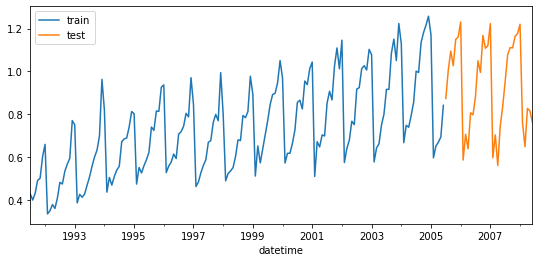

In [ ]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                    regressor = Ridge(),
                    steps     = 4,
                    lags      = 2
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregDirect 
Regressor: Ridge() 
Lags: [1 2] 
Transformer for y: None 
Transformer for exog: None 
Window size: 2 
Maximum steps predicted: 4 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-07-27 13:34:06 
Last fit date: 2022-07-27 13:34:06 
Skforecast version: 0.5.dev1 

In [ ]:
y = pd.Series(range(0,20), name='y')
exog = pd.Series(range(0,20), name='exog')

In [ ]:
X, y = forecaster.create_train_X_y(y=y, exog=exog)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 2,
                X_train = X,
                y_train = y,
           )

X_1.head(4)

,lag_1,lag_2,exog_step_3
5,1.0,0.0,4.0
6,2.0,1.0,5.0
7,3.0,2.0,6.0
8,4.0,3.0,7.0


In [ ]:
forecaster.fit(y=y, exog=exog)
forecaster.predict(exog=exog)

Exception: `y` must be a pandas Series.

In [ ]:
exog.iloc[:4, ]

0    0
1    1
2    2
3    3
Name: exog, dtype: int64

In [ ]:
steps = 4
exog_values, _ = preprocess_exog(
                                exog = exog.iloc[:steps, ]
                             )

exog_values

NameError: name 'preprocess_exog' is not defined

In [ ]:
X, y = forecaster.create_train_X_y(data_train)
# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
                step    = 1,
                X_train = X,
                y_train = y,
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164
datetime,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0.597639,1.17069,1.257238,1.216037,1.181011,1.134432,0.994864,1.001593,0.856803,0.795129,...,0.379808,0.351348,0.33622,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795


In [ ]:
y.head(4)

,y_step_0,y_step_1,y_step_2,y_step_3
datetime,,,,
2005-06-01,0.65259,0.670505,0.695248,0.842263


In [ ]:
data

datetime
1991-07-01    0.429795
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
                ...   
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, Length: 204, dtype: float64

In [ ]:
forecaster.predict()

2005-07-01    0.652590
2005-08-01    0.670505
2005-09-01    0.695248
2005-10-01    0.842263
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Test

In [ ]:
y = pd.Series(
            np.array([-0.59,  0.02, -0.9 ,  1.09, -3.61,  0.72, -0.11, -0.4 ,  0.49,
                       0.67,  0.54, -0.17,  0.54,  1.49, -2.26, -0.41, -0.64, -0.8 ,
                      -0.61, -0.88])
        )

In [ ]:
forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags = 5,
                    steps = 5,
                    transformer_y = StandardScaler(),
                )
forecaster.fit(y = y)
predictions = forecaster.predict()
print(predictions)

20    0.274988
21    0.113467
22    0.382425
23    0.628522
24    0.440017
Name: pred, dtype: float64


In [ ]:
m = StandardScaler().fit(y.values.reshape(-1, 1))
y_transform = m.transform(y.values.reshape(-1, 1))
y_transform = pd.Series(y_transform.flatten())

forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags = 5,
                    steps = 5,
                    transformer_y = None,
                )
forecaster.fit(y = y_transform)
predictions = forecaster.predict()
predictions = m.inverse_transform(predictions.values.reshape(-1, 1))
pd.Series(predictions.flatten()).values

array([0.27498792, 0.1134674 , 0.3824246 , 0.62852197, 0.44001725])

In [ ]:
y = pd.Series(
            np.array([-0.59,  0.02, -0.9 ,  1.09, -3.61,  0.72, -0.11, -0.4 ,  0.49,
                       0.67,  0.54, -0.17,  0.54,  1.49, -2.26, -0.41, -0.64, -0.8 ,
                      -0.61, -0.88])
        )
exog = pd.DataFrame({
            'col_1': [7.5, 24.4, 60.3, 57.3, 50.7, 41.4, 87.2, 47.4, 60.3, 87.2,
                      7.5, 60.4, 50.3, 57.3, 24.7, 87.4, 87.2, 60.4, 50.7, 7.5],
            'col_2': ['a']*10 + ['b']*10}
       )

In [ ]:
from skforecast.utils import preprocess_exog
from skforecast.utils import exog_to_multi_output
steps = 5

exog_values, _ = preprocess_exog(
                                exog = exog.iloc[:steps, ]
                             )

print(exog_values)

exog_values = exog_to_multi_output(exog=exog_values, steps=steps)

print(exog_values)

exog_values = exog_values[0][0::steps].reshape(1, -1)

exog_values

[[7.5 'a']
 [24.4 'a']
 [60.3 'a']
 [57.3 'a']
 [50.7 'a']]
[[7.5 24.4 60.3 57.3 50.7 'a' 'a' 'a' 'a' 'a']]


array([[7.5, 'a']], dtype=object)

In [ ]:
transformer_exog = ColumnTransformer(
                            [('scale', StandardScaler(), ['col_1']),
                             ('onehot', OneHotEncoder(), ['col_2'])],
                            remainder = 'passthrough',
                            verbose_feature_names_out = False
                       )
forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags = 5,
                    steps = 5,
                    transformer_y = StandardScaler(),
                    transformer_exog = transformer_exog
             )
forecaster.fit(y=y, exog=exog)
predictions = forecaster.predict(exog=exog)
print(predictions)

20    1.108551
21   -0.834424
22    0.943444
23    0.667651
24    0.586663
Name: pred, dtype: float64


In [ ]:
m = StandardScaler().fit(y.values.reshape(-1, 1))
y_transform = m.transform(y.values.reshape(-1, 1))
y_transform = pd.Series(y_transform.flatten())

v = StandardScaler()
v.fit(exog['col_1'].values.reshape(-1, 1))
exog_transform_1 = v.transform(exog['col_1'].values.reshape(-1, 1))

df_transformed = pd.DataFrame({'col_1': exog_transform_1.flatten(), 
                               'col_2_a': [1]*10 + [0]*10,
                               'col_2_b': [0]*10 + [1]*10})
df_transformed.head()

,col_1,col_2_a,col_2_b
0,-1.709307,1,0
1,-1.043010,1,0
2,0.372377,1,0
3,0.254100,1,0
4,-0.006111,1,0


In [ ]:
forecaster = ForecasterAutoregDirect(
                    regressor = LinearRegression(),
                    lags = 5,
                    steps = 5,
                    transformer_y = None,
                    transformer_exog = None
             )

forecaster.fit(y = y_transform, 
               exog = df_transformed[['col_1', 'col_2_a', 'col_2_b']])

predictions = forecaster.predict(exog = df_transformed[['col_1', 'col_2_a', 'col_2_b']])
predictions = m.inverse_transform(predictions.values.reshape(-1, 1))
pd.Series(predictions.flatten()).values

array([ 1.10855119, -0.83442443,  0.9434436 ,  0.6676508 ,  0.58666266])

## Backtesting_multiple_metric

In [ ]:
from skforecast.model_selection.model_selection import _get_metric

from sklearn.metrics import mean_squared_error

In [ ]:
_get_metric('mean_squared_error')

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [ ]:
mean_squared_error

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [ ]:
metric = ['mean_squared_error', mean_squared_error]

In [ ]:
metrics = [_get_metric(metric=m) if isinstance(m, str) else m for m in metric]

In [ ]:
metrics[0]

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [ ]:
from skforecast.model_selection.model_selection import _evaluate_grid_hyperparameters
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
y = pd.Series(
    np.array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
              0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
              0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
              0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
              0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
              0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
              0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
              0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
              0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
              0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]))

In [ ]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
y_train = y[:-n_validation]
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
idx = len(lags_grid)*len(param_grid)

results = _evaluate_grid_hyperparameters(
                        forecaster  = forecaster,
                        y           = y,
                        lags_grid   = lags_grid,
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = ['mean_squared_error', mean_absolute_percentage_error],
                        initial_train_size = len(y_train),
                        fixed_train_size   = False,
                        return_best = False,
                        verbose     = False
          )

results

Number of models compared: 6.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 57.33it/s]


,lags,params,mean_squared_error,mean_absolute_percentage_error,alpha
0,"[1, 2]",{'alpha': 0.01},0.064646,0.584517,0.01
1,"[1, 2]",{'alpha': 0.1},0.065024,0.583482,0.10
2,"[1, 2]",{'alpha': 1},0.067455,0.577341,1.00
3,"[1, 2, 3, 4]",{'alpha': 0.01},0.067793,0.627959,0.01
4,"[1, 2, 3, 4]",{'alpha': 0.1},0.068025,0.625030,0.10
5,"[1, 2, 3, 4]",{'alpha': 1},0.069486,0.606975,1.00


In [ ]:
results.sort_values(by='mean_absolute_percentage_error')

,lags,params,mean_squared_error,mean_absolute_percentage_error,alpha
2,"[1, 2]",{'alpha': 1},0.067455,0.577341,1.00
1,"[1, 2]",{'alpha': 0.1},0.065024,0.583482,0.10
0,"[1, 2]",{'alpha': 0.01},0.064646,0.584517,0.01
5,"[1, 2, 3, 4]",{'alpha': 1},0.069486,0.606975,1.00
4,"[1, 2, 3, 4]",{'alpha': 0.1},0.068025,0.625030,0.10
3,"[1, 2, 3, 4]",{'alpha': 0.01},0.067793,0.627959,0.01


In [ ]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
y_train = y[:-n_validation]
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

r =_evaluate_grid_hyperparameters(
        forecaster  = forecaster,
        y           = y,
        lags_grid   = lags_grid,
        param_grid  = param_grid,
        steps       = steps,
        refit       = False,
        metric      = [mean_squared_error, 'mean_squared_error'],
        initial_train_size = len(y_train),
        fixed_train_size   = False,
        return_best = True,
        verbose     = False
)

expected_lags = np.array([1, 2])
expected_alpha = 1.

assert (expected_lags == forecaster.lags).all()
assert expected_alpha == forecaster.regressor.alpha

ValueError: When `metrics` is a `list`, each metric name must be unique.

In [ ]:
r

,lags,params,mean_absolute_percentage_error,mean_squared_error,alpha
2,"[1, 2]",{'alpha': 1},0.577341,0.067455,1.00
1,"[1, 2]",{'alpha': 0.1},0.583482,0.065024,0.10
0,"[1, 2]",{'alpha': 0.01},0.584517,0.064646,0.01
5,"[1, 2, 3, 4]",{'alpha': 1},0.606975,0.069486,1.00
4,"[1, 2, 3, 4]",{'alpha': 0.1},0.625030,0.068025,0.10
3,"[1, 2, 3, 4]",{'alpha': 0.01},0.627959,0.067793,0.01


In [ ]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
y_train = y[:-n_validation]
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

r = _evaluate_grid_hyperparameters(
        forecaster  = forecaster,
        y           = y,
        lags_grid   = lags_grid,
        param_grid  = param_grid,
        steps       = steps,
        refit       = False,
        metric      = 'mean_squared_error',
        initial_train_size = len(y_train),
        fixed_train_size   = False,
        return_best = True,
        verbose     = False
)

expected_lags = np.array([1, 2])
expected_alpha = 0.01

assert (expected_lags == forecaster.lags).all()
assert expected_alpha == forecaster.regressor.alpha

Number of models compared: 6.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 57.34it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.06464646415433532



In [ ]:
r

,lags,params,metric,alpha
0,"[1, 2]",{'alpha': 0.01},0.064646,0.01
1,"[1, 2]",{'alpha': 0.1},0.065024,0.10
2,"[1, 2]",{'alpha': 1},0.067455,1.00
3,"[1, 2, 3, 4]",{'alpha': 0.01},0.067793,0.01
4,"[1, 2, 3, 4]",{'alpha': 0.1},0.068025,0.10
5,"[1, 2, 3, 4]",{'alpha': 1},0.069486,1.00


In [ ]:
import pytest
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # hide progress bar

# Fixtures
# np.random.seed(123)
# series_1 = np.random.rand(50)
# series_2 = np.random.rand(50)
series = pd.DataFrame({'1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                      )
                            ), 
                       '2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      )
                            )
                      }
         )

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 3
                 )

levels_list = '1'
r =_evaluate_grid_hyperparameters_multiseries(
    forecaster          = forecaster,
    series              = series,
    param_grid          = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
    steps               = 4,
    metric              = ['mean_absolute_error', mean_absolute_error],
    initial_train_size  = 12,
    fixed_train_size    = False,
    levels_list         = levels_list,
    levels_weights      = None,
    exog                = None,
    lags_grid           = [2, 4],
    refit               = False,
    return_best         = False,
    verbose             = False
)

6 models compared for 1 level(s). Number of iterations: 6.


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
r

,levels,lags,params,metric,alpha
2,[1],"[1, 2]",{'alpha': 1},0.207948,1.00
1,[1],"[1, 2]",{'alpha': 0.1},0.212652,0.10
0,[1],"[1, 2]",{'alpha': 0.01},0.213753,0.01
5,[1],"[1, 2, 3, 4]",{'alpha': 1},0.225484,1.00
4,[1],"[1, 2, 3, 4]",{'alpha': 0.1},0.245119,0.10
3,[1],"[1, 2, 3, 4]",{'alpha': 0.01},0.250007,0.01


In [ ]:
from skforecast.model_selection.model_selection import _backtesting_forecaster_verbose

index_values = pd.DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
                                 '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
                                 '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
                                 '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
                                 '2022-01-17', '2022-01-18', '2022-01-19'],
                                 dtype='datetime64[ns]', name='date', freq='D')

steps = 3
refit = False
initial_train_size = 5
fixed_train_size = False
folds = int(np.ceil((len(index_values) - initial_train_size) / steps))
remainder = (len(index_values) - initial_train_size) % steps

_backtesting_forecaster_verbose(
    index_values       = index_values,
    steps              = steps,
    refit              = refit,
    initial_train_size = initial_train_size,
    fixed_train_size   = fixed_train_size,
    folds              = folds,
    remainder          = remainder
)

out, _ = capfd.readouterr()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 5
Number of observations used for backtesting: 14
    Number of folds: 5
    Number of steps per fold: 3
    Last fold only includes 2 observations.

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-05 00:00:00  (n=5)
    Validation: 2022-01-06 00:00:00 -- 2022-01-08 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-05 00:00:00  (n=5)
    Validation: 2022-01-09 00:00:00 -- 2022-01-11 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2022-01-01 00:00:00 -- 2022-01-05 00:00:00  (n=5)
    Validation: 2022-01-12 00:00:00 -- 2022-01-14 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2022-01-01 00:00:00 -- 2022-01-05 00:00:00  (n=5)
    Validation: 2022-01-15 00:00:00 -- 2022-01-17 00:00:00  (n=3)
Data partition in fold: 4
    Training:   2022-01-01 00:00:00 -- 2022-01-05 00:00:00  (n=5)
    Va

NameError: name 'capfd' is not defined

In [ ]:
series = pd.DataFrame({'1': pd.Series(np.array(
                                [0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                                 0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                                 0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                                 0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                                 0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                                 0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                                 0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                                 0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                                 0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                                 0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
                                      )
                            ), 
                       '2': pd.Series(np.array(
                                [0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                                 0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                                 0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                                 0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                                 0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                                 0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                                 0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                                 0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                                 0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                                 0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
                                      )
                            )
                      }
         )

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

_evaluate_grid_hyperparameters_multiseries(
    forecaster          = forecaster,
    series              = series,
    param_grid          = param_grid,
    steps               = steps,
    metric              = 'mean_absolute_error',
    initial_train_size  = len(series) - n_validation,
    fixed_train_size    = False,
    levels_list         = None,
    levels_weights      = None,
    exog                = None,
    lags_grid           = lags_grid,
    refit               = False,
    return_best         = True,
    verbose             = False
)

expected_lags = np.array([1, 2])
expected_alpha = 0.01
expected_series_levels = ['1', '2']

assert (expected_lags == forecaster.lags).all()
assert expected_alpha == forecaster.regressor.alpha
assert expected_series_levels ==  forecaster.series_levels

6 models compared for 2 level(s). Number of iterations: 12.
Level weights for metric evaluation: {'1': 0.5, '2': 0.5}
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.20968100547390045
  Levels: ['1', '2'] 
  Levels weights: {'1': 0.5, '2': 0.5} 



C:\Users\jaesc2\AppData\Local\Temp\ipykernel_25240\643335328.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert (expected_lags == forecaster.lags).all()


AttributeError: 'bool' object has no attribute 'all'

In [ ]:
forecaster.lags

array([1, 2, 3, 4])

In [ ]:
(np.array([1, 2, 3, 4]) == forecaster.lags).all()

True

In [ ]:
import pytest
import re
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe

In [ ]:
df_input = pd.DataFrame({
                'col_1': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'col_2': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
            })
transformer = OneHotEncoder()
transformer.fit(df_input)
df_input_2 = transformer.transform(df_input)

results =  transform_dataframe(
                df = df_input_2,
                transformer = transformer,
                fit = False,
                inverse_transform = True
           )

AttributeError: index not found

In [ ]:
df_input = pd.Series(['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], name= 'col_1')

transformer = OneHotEncoder()
# transformer.fit(df_input)

# df_input_2 = transformer.transform(df_input)

results =  transform_series(
                series = df_input,
                transformer = transformer,
                fit = True,
                inverse_transform = False
           )

AttributeError: flatten not found

In [ ]:
transformer.inverse_transform(df_input_2)

array([['a', 'a'],
       ['a', 'a'],
       ['a', 'a'],
       ['a', 'a'],
       ['b', 'b'],
       ['b', 'b'],
       ['b', 'b'],
       ['b', 'b']], dtype=object)

In [ ]:
transformer.get_feature_names_out()

array(['col_1_a', 'col_1_b', 'col_2_a', 'col_2_b'], dtype=object)

In [ ]:
transformer.get_feature_names_out()

array(['col_1_a', 'col_1_b', 'col_2_a', 'col_2_b'], dtype=object)

In [ ]:
transformer.feature_names_in_

array(['col_1', 'col_2'], dtype=object)